# Official Efficiency Plots for 2017 and 2018

Dedicated notebook to produce all efficiency plots (2017 and 2018) to ringer note/paper.

2017 after TS1 has an integrated luminosity of 13.2 fb-1 
2017 before TS1 6 fb-1

In [1]:
import os
import rootplotlib as rpl

import ROOT
from tqdm import tqdm
from copy import deepcopy     
from ROOT import TLegend ,TH1,TH2
from ROOT import kBlack,kBlue,kRed,kAzure,kGreen,kMagenta,kCyan,kOrange,kGray,kYellow,kWhite,TColor,gStyle
from expand_folders import expand_folders
from prettytable import PrettyTable
from typing import Sequence


rpl.set_atlas_style()
rpl.suppress_root_warnings()
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

Module libc not found.


Welcome to JupyROOT 6.26/10

Applying ATLAS style settings...


In [2]:

def GetHistogramRootPaths( triggerList, removeInnefBefore=False, is_emulation=False):
  
  plot_names = ['et','eta','mu']
  level_names = ['L1Calo','L2Calo','L2','EFCalo','HLT']
  levels_input = ['L1Calo','L1Calo','L1Calo','L2','EFCalo']
  paths=[]; keys=[]

  def check_etthr_higher_than(trigger , etthr):
      et = int(trigger.replace('HLT_','').split('_')[0][1::])
      return True if et >= etthr else False

  entries=len(triggerList)
  step = int(entries/100) if int(entries/100) > 0 else 1
  for trigItem in tqdm(triggerList, desc='Making paths...', total=len(triggerList),  bar_format='{desc:<5.5}{percentage:3.0f}%|{bar:10}{r_bar}'):
    ### Retrieve all paths
    for idx ,level in enumerate(level_names):
      for histname in plot_names:
        if 'et' == histname and check_etthr_higher_than(trigItem,100):  histname='highet'
        if is_emulation:
          histpath = 'HLT/Egamma/Expert/{TRIGGER}/Emulation/{LEVEL}/{HIST}'
        else:
          histpath = 'HLT/Egamma/Expert/{TRIGGER}/Efficiency/{LEVEL}/{HIST}'
        paths.append(histpath.format(TRIGGER=trigItem,HIST='match_'+histname,LEVEL=level))
        if removeInnefBefore:
          paths.append(histpath.format(TRIGGER=trigItem,HIST= ('match_'+histname if idx!=0 else histname),LEVEL=levels_input[idx]))
        else:
          paths.append(histpath.format(TRIGGER=trigItem,HIST=histname,LEVEL='L1Calo'))
        if 'highet' == histname:  histname='et'
        keys.append(trigItem+'_'+level+'_match_'+histname)
        keys.append(trigItem+'_'+level+'_'+histname)
  # Loop over triggers
  return paths, keys


def GetXAxisWorkAround( hist, nbins, xmin, xmax ):
  from ROOT import TH1F
  h=TH1F(hist.GetName()+'_resize', hist.GetTitle(), nbins,xmin,xmax)
  for bin in range(h.GetNbinsX()):
    x = h.GetBinCenter(bin+1)
    m_bin = hist.FindBin(x)
    y = hist.GetBinContent(m_bin)
    error = hist.GetBinError(m_bin)
    h.SetBinContent(bin+1,y)
    h.SetBinError(bin+1,error)
  return h


def GetProfile( passed, tot, resize=None):
    """
      Resize optin must be a list with [nbins, xmin, xmax]
    """
    if resize:
        tot=GetXAxisWorkAround(tot,resize[0],resize[1],resize[2])
        passed=GetXAxisWorkAround(passed,resize[0],resize[1],resize[2])
    passed.Sumw2(); tot.Sumw2()
    h = passed.Clone()
    h.Divide( passed, tot,1.,1.,'B' )
    return h


def GetHistogramFromMany( basepath, paths, keys ,  prefix='Loading...'):
    # internal open function
    def Open( path ):
        from ROOT import TFile
        f = TFile(path, 'read')
        if len(f.GetListOfKeys())>0:
            run_numbers = [ key.GetName() for key in  f.GetListOfKeys() ]
            return f, run_numbers
        else:
            return f, None
    # internal close function
    def Close( f ):
        f.Close()
        del f
    # internal retrive histogram
    def GetHistogram( f, run_number, path ,logger=None):
        try:            
            hist = f.Get(run_number+'/'+path)
            hist.GetEntries()
            return hist
            
        except:
            return None
    # internal integration
    def SumHists(histList):
        totalHist = None
        for hist in histList:
            if hist is None:
                continue
            if totalHist is None:
                totalHist=deepcopy(hist.Clone())
            else:
                totalHist.Add( hist )
        return totalHist

    files = expand_folders(basepath)
    hists = {}
    for f in tqdm(files, desc='Loading', bar_format='{desc:<5.5}{percentage:3.0f}%|{bar:10}{r_bar}'):
        try:
            _f, _run_numbers = Open(f)
        except:
            continue
        if _run_numbers is None:
            continue
        for idx, _path in enumerate(paths):
            for _run_number in _run_numbers:
                hist = GetHistogram(_f, _run_number, _path)
                if (hist is not None):
                    if not keys[idx] in hists.keys():
                        hists[keys[idx]]=[deepcopy(hist.Clone())]
                    else:
                        hists[keys[idx]].append(deepcopy(hist.Clone()))
        Close(_f)

    for key in hists.keys():
        hists[key]=SumHists(hists[key])
    return hists


## 1) Read all files:

### 1.1) Create keys and paths

In [3]:
triggers = [
            'HLT_e28_lhtight_nod0_ivarloose',
            'HLT_e28_lhtight_nod0_noringer_ivarloose',
            'HLT_e17_lhvloose_nod0_L1EM15VHI',
            'HLT_e26_lhtight_nod0_ivarloose',
            'HLT_e60_lhmedium_nod0',
            'HLT_e140_lhloose_nod0',
            ]
paths, keys =  GetHistogramRootPaths( triggers, removeInnefBefore=False, is_emulation=False)

Makin100%|██████████| 6/6 [00:00<00:00, 43314.67it/s]


### 1.2) Read 2017 data:

In [4]:
path = '/mnt/cern_data/joao.pinto/data17_13TeV/Mon/EGAM1/before_ts1'
h_data17_before_ts1 = GetHistogramFromMany(path, paths, keys)

Loadi100%|██████████| 188/188 [00:00<00:00, 220.08it/s]


In [5]:
path = '/mnt/cern_data/joao.pinto/data17_13TeV/Mon/EGAM1/after_ts1'
h_data17_after_ts1 = GetHistogramFromMany(path, paths, keys)

Loadi100%|██████████| 1472/1472 [00:09<00:00, 159.65it/s]


In [6]:
path = '/mnt/cern_data/joao.pinto/data17_13TeV/Mon/EGAM7/before_ts1/user.*'
h_data17_before_ts1_egam7 = GetHistogramFromMany(path, paths, keys)

Loadi100%|██████████| 172/172 [00:01<00:00, 121.27it/s]


In [7]:
path = '/mnt/cern_data/joao.pinto/data17_13TeV/Mon/EGAM7/after_ts1'
h_data17_after_ts1_egam7 = GetHistogramFromMany(path, paths, keys)

Loadi100%|██████████| 1373/1373 [00:17<00:00, 77.85it/s]


### 1.3) Read 2018 data:

In [8]:
path = '/mnt/cern_data/joao.pinto/data18_13TeV/Mon/EGAM1_merged/user.*'
h_data18 = GetHistogramFromMany(path, paths, keys)

Loadi100%|██████████| 10/10 [00:06<00:00,  1.48it/s]


In [9]:
path = '/mnt/cern_data/joao.pinto/data18_13TeV/Mon/EGAM7/user.*'
h_data18_egam7 = GetHistogramFromMany(path, paths, keys)

Loadi100%|██████████| 513/513 [00:09<00:00, 52.53it/s]


## 2) Official plots (e28 ringer vs noringer 2017, after TS1):

Compare ringer and noringer (backup triggers) chains.

In [10]:
def add_legend( x, y, legends, textsize=14, pad=None):
    rpl.add_legend( legends,x,y,x+0.98,y+0.20,textsize=textsize, option='p', pad=pad)

def set_marker_size( fig, marker_size , pad=None):
    canvas = fig.get_pad(pad)
    for primitive in canvas.GetListOfPrimitives():
        if issubclass(type(primitive), TH1) or issubclass(type(primitive),TH2):
            primitive.SetMarkerSize(marker_size)

In [11]:
os.makedirs('output', exist_ok=True)

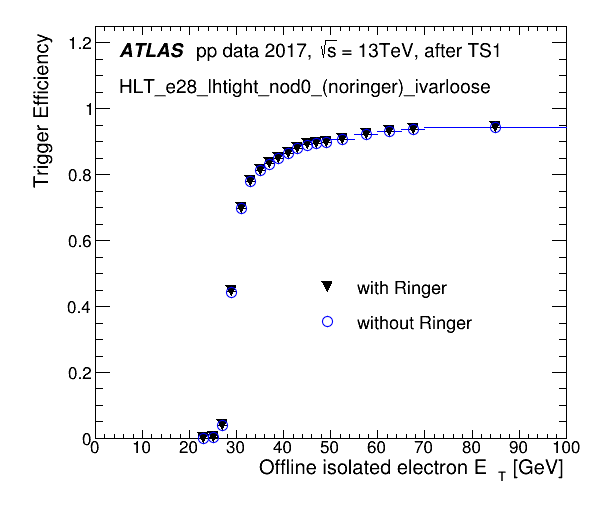

In [23]:
colors = [kBlack,kBlue]
markers = [23, 24]

hists = [
            rpl.hist1d.divide( h_data17_after_ts1['HLT_e28_lhtight_nod0_ivarloose_HLT_match_et'],
                               h_data17_after_ts1['HLT_e28_lhtight_nod0_ivarloose_HLT_et']),
            rpl.hist1d.divide( h_data17_after_ts1['HLT_e28_lhtight_nod0_noringer_ivarloose_HLT_match_et'],
                               h_data17_after_ts1['HLT_e28_lhtight_nod0_noringer_ivarloose_HLT_et']),
        ]
[h.SetMarkerSize(200) for h in hists]
fig = rpl.plot_profiles( hists, 'Offline isolated electron E_{T} [GeV]', 'Trigger Efficiency',  
                         colors, markers, name='',title='',canw=600, canh=550 )
#rpl.set_atlas_label(0.2,0.88,'Internal, pp data 2017 #sqrt{s}= 13TeV', textsize=0.06

set_marker_size(fig, 1.4)
rpl.add_text( 0.2, 0.89, 'ATLAS'   , textsize=0.04, textfont=72)
rpl.add_text( 0.33, 0.89, 'pp data 2017, #sqrt{s} = 13TeV, after TS1', textsize=0.04)
rpl.add_text( 0.2, 0.82, 'HLT_e28_lhtight_nod0_(noringer)_ivarloose', textsize=0.04)
add_legend( 0.5,0.35,['with Ringer', 'without Ringer'] , 20)
rpl.set_yaxis_ranges(0, 1.25) #, pad='pad_top')

fig.show()
fig.savefig('output/eff_EGAM1_e28_ringer_and_noringer_2017_after_ts1_HLT_et.pdf')

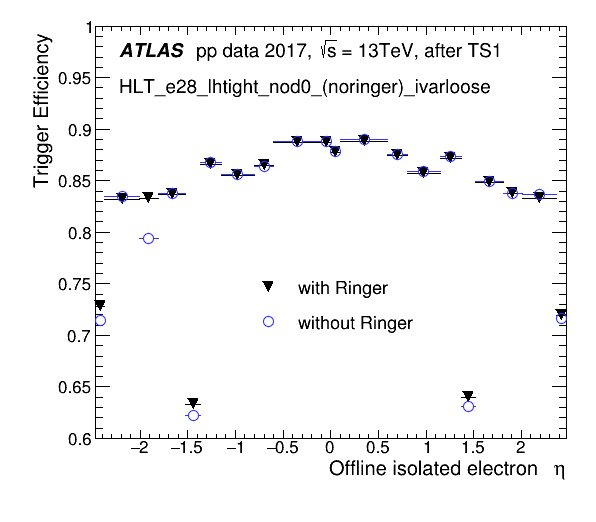

In [34]:
colors = [kBlack,kBlue-4]
markers = [23, 24]

hists = [
            rpl.hist1d.divide( h_data17_after_ts1['HLT_e28_lhtight_nod0_ivarloose_HLT_match_eta'],
                               h_data17_after_ts1['HLT_e28_lhtight_nod0_ivarloose_HLT_eta']),
            rpl.hist1d.divide( h_data17_after_ts1['HLT_e28_lhtight_nod0_noringer_ivarloose_HLT_match_eta'],
                               h_data17_after_ts1['HLT_e28_lhtight_nod0_noringer_ivarloose_HLT_eta']),
        ]
fig = rpl.plot_profiles( hists, 'Offline isolated electron #eta', 'Trigger Efficiency',  
                         colors, markers, name='',title='',canw=600, canh=550 )
set_marker_size(fig, 1.4)

rpl.add_text( 0.2, 0.89, 'ATLAS'   , textsize=0.04, textfont=72)
rpl.add_text( 0.33, 0.89, 'pp data 2017, #sqrt{s} = 13TeV, after TS1', textsize=0.04)
rpl.add_text( 0.2, 0.82, 'HLT_e28_lhtight_nod0_(noringer)_ivarloose', textsize=0.04)
add_legend( 0.4,0.35,['with Ringer', 'without Ringer'] , 20)
rpl.set_yaxis_ranges(0.6, 1.0)

fig.show()
fig.savefig('output/eff_EGAM1_e28_ringer_and_noringer_2017_after_ts1_HLT_eta.pdf')

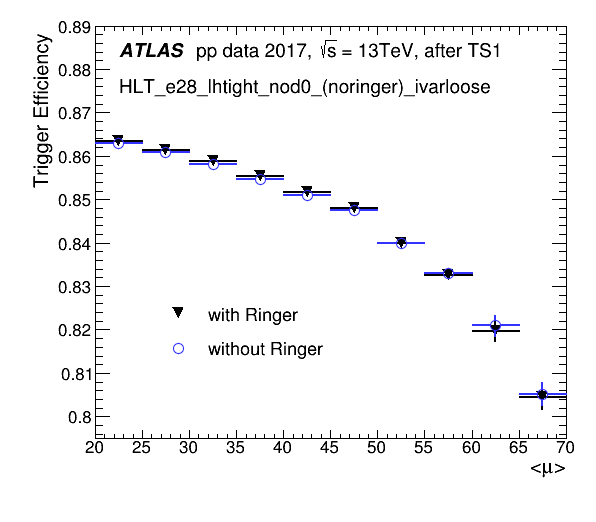

In [33]:
colors = [kBlack,kBlue-4]
markers = [23, 24]

hists = [
            h_data17_after_ts1['HLT_e28_lhtight_nod0_ivarloose_HLT_match_mu'],
            h_data17_after_ts1['HLT_e28_lhtight_nod0_ivarloose_HLT_mu'],
            h_data17_after_ts1['HLT_e28_lhtight_nod0_noringer_ivarloose_HLT_match_mu'],
            h_data17_after_ts1['HLT_e28_lhtight_nod0_noringer_ivarloose_HLT_mu'],
]
hists = [ rpl.hist1d.rebin( h , 10, 20, 70 ) for h in hists ]

hists = [ rpl.hist1d.divide( hists[0], hists[1] ), rpl.hist1d.divide(hists[2], hists[3]) ]

#fig = rpl.create_canvas('my_canvas')
fig = rpl.plot_profiles( hists, '<#mu>', 'Trigger Efficiency',  colors, markers,
                         name='',title='',canw=600, canh=550 )
set_marker_size(fig, 1.4)

rpl.add_text( 0.2, 0.89, 'ATLAS'   , textsize=0.04, textfont=72)
rpl.add_text( 0.33, 0.89, 'pp data 2017, #sqrt{s} = 13TeV, after TS1', textsize=0.04)
rpl.add_text( 0.2, 0.82, 'HLT_e28_lhtight_nod0_(noringer)_ivarloose', textsize=0.04)
add_legend( 0.25,0.3,['with Ringer', 'without Ringer'] , 20)
rpl.set_yaxis_ranges(0.795, 0.89)

fig.show()
fig.savefig('output/eff_EGAM1_e28_ringer_and_noringer_2017_after_ts1_HLT_mu.pdf')

### 2.1) Check fake rejection for FastCalo step:

**NOTE**: For Run-2, to get the fast-calo boolean, point the histogram to L2

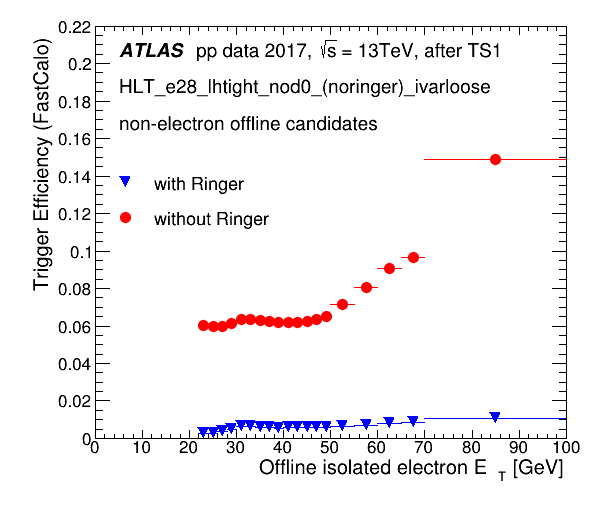

In [61]:
colors = [kBlue,kRed]
markers = [23, 20]
hists = [
            rpl.hist1d.divide(h_data17_after_ts1_egam7['HLT_e28_lhtight_nod0_ivarloose_L2_match_et'],
                              h_data17_after_ts1_egam7['HLT_e28_lhtight_nod0_ivarloose_L2_et']),
            rpl.hist1d.divide(h_data17_after_ts1_egam7['HLT_e28_lhtight_nod0_noringer_ivarloose_L2_match_et'],
                              h_data17_after_ts1_egam7['HLT_e28_lhtight_nod0_noringer_ivarloose_L2_et']),
]


fig = rpl.plot_profiles( hists, 'Offline isolated electron E_{T} [GeV]', 'Trigger Efficiency (FastCalo)', colors, markers,
                         name='',title='',canw=600, canh=550 )

set_marker_size(fig, 1.4)
rpl.add_text( 0.2, 0.89, 'ATLAS'   , textsize=0.04, textfont=72)
rpl.add_text( 0.33, 0.89, 'pp data 2017, #sqrt{s} = 13TeV, after TS1', textsize=0.04)
rpl.add_text( 0.2, 0.82, 'HLT_e28_lhtight_nod0_(noringer)_ivarloose', textsize=0.04)
rpl.add_text( 0.2, 0.75, 'non-electron offline candidates', textsize=0.04)
add_legend( 0.16,0.55,['with Ringer', 'without Ringer'] , 20)

rpl.set_yaxis_ranges(0.0, 0.22)
fig.show()
fig.savefig('output/eff_EGAM7_e28_ringer_and_noringer_2017_after_ts1_L2Calo_et.pdf')

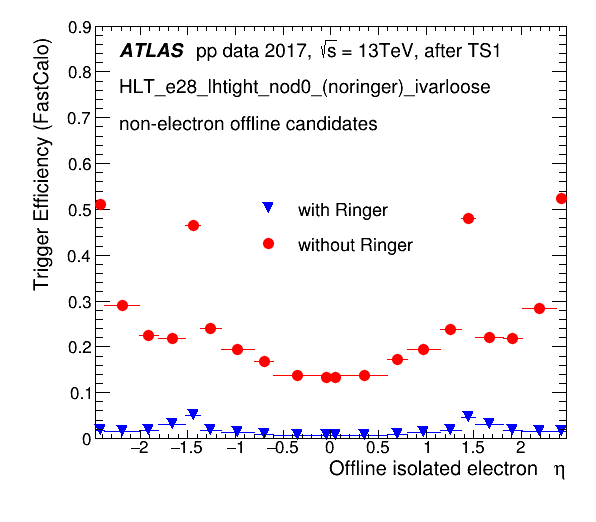

In [59]:
colors = [kBlue,kRed]
markers = [23, 20]
hists = [
            rpl.hist1d.divide(h_data17_after_ts1_egam7['HLT_e28_lhtight_nod0_ivarloose_L2_match_eta'],
                              h_data17_after_ts1_egam7['HLT_e28_lhtight_nod0_ivarloose_L2_eta']),
            rpl.hist1d.divide(h_data17_after_ts1_egam7['HLT_e28_lhtight_nod0_noringer_ivarloose_L2_match_eta'],
                              h_data17_after_ts1_egam7['HLT_e28_lhtight_nod0_noringer_ivarloose_L2_eta']),
]

fig = rpl.plot_profiles( hists, 'Offline isolated electron #eta',  'Trigger Efficiency (FastCalo)', colors, markers,
                       name='',title='',canw=600, canh=550)
set_marker_size(fig, 1.4)
rpl.add_text( 0.2, 0.89, 'ATLAS'   , textsize=0.04, textfont=72)
rpl.add_text( 0.33, 0.89, 'pp data 2017, #sqrt{s} = 13TeV, after TS1', textsize=0.04)
rpl.add_text( 0.2, 0.82, 'HLT_e28_lhtight_nod0_(noringer)_ivarloose', textsize=0.04)
rpl.add_text( 0.2, 0.75, 'non-electron offline candidates', textsize=0.04)
add_legend( 0.4,0.5,['with Ringer', 'without Ringer'] , 20)
rpl.set_yaxis_ranges(0, 0.9)
fig.show()
fig.savefig('output/eff_EGAM7_e28_ringer_and_noringer_2017_after_ts1_L2Calo_eta.pdf')

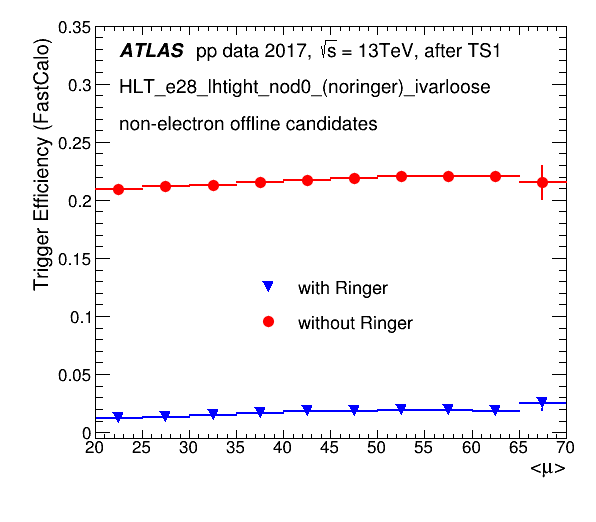

In [80]:
colors = [kBlue,kRed]
markers = [23, 20]
hists = [
            h_data17_after_ts1_egam7['HLT_e28_lhtight_nod0_ivarloose_L2_match_mu'],
            h_data17_after_ts1_egam7['HLT_e28_lhtight_nod0_ivarloose_L2_mu'],
            h_data17_after_ts1_egam7['HLT_e28_lhtight_nod0_noringer_ivarloose_L2_match_mu'],
            h_data17_after_ts1_egam7['HLT_e28_lhtight_nod0_noringer_ivarloose_L2_mu'],
        ]

hists = [ rpl.hist1d.rebin( h , 10, 20, 70 ) for h in hists ]
hists = [ rpl.hist1d.divide( hists[0], hists[1] ), rpl.hist1d.divide(hists[2], hists[3]) ]

fig = rpl.plot_profiles( hists, '<#mu>',  'Trigger Efficiency (FastCalo)', colors, markers,
                       name='',title='',canw=600, canh=550)
set_marker_size(fig, 1.4)
rpl.add_text( 0.2, 0.89, 'ATLAS'   , textsize=0.04, textfont=72)
rpl.add_text( 0.33, 0.89, 'pp data 2017, #sqrt{s} = 13TeV, after TS1', textsize=0.04)
rpl.add_text( 0.2, 0.82, 'HLT_e28_lhtight_nod0_(noringer)_ivarloose', textsize=0.04)
rpl.add_text( 0.2, 0.75, 'non-electron offline candidates', textsize=0.04)
add_legend( 0.4,0.35,['with Ringer', 'without Ringer'] , 20)
rpl.set_yaxis_ranges(-0.005, 0.35)

fig.show()
fig.savefig('output/eff_EGAM7_e28_ringer_and_noringer_2017_after_ts1_L2Calo_mu.pdf')

### 2.2) Check fake rejection for HLT step:



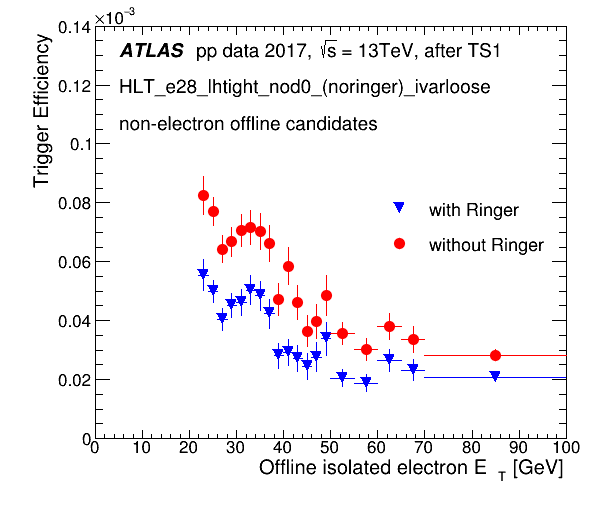

In [63]:
colors = [kBlue,kRed]
markers = [23, 20]
hists = [
            rpl.hist1d.divide(h_data17_after_ts1_egam7['HLT_e28_lhtight_nod0_ivarloose_HLT_match_et'],
                              h_data17_after_ts1_egam7['HLT_e28_lhtight_nod0_ivarloose_HLT_et']),
            rpl.hist1d.divide(h_data17_after_ts1_egam7['HLT_e28_lhtight_nod0_noringer_ivarloose_HLT_match_et'],
                              h_data17_after_ts1_egam7['HLT_e28_lhtight_nod0_noringer_ivarloose_HLT_et']),
]

fig = rpl.plot_profiles( hists, 'Offline isolated electron E_{T} [GeV]', 'Trigger Efficiency',  colors, markers,
                       name='',title='',canw=600, canh=550)
set_marker_size(fig, 1.4)
rpl.add_text( 0.2, 0.89, 'ATLAS'   , textsize=0.04, textfont=72)
rpl.add_text( 0.33, 0.89, 'pp data 2017, #sqrt{s} = 13TeV, after TS1', textsize=0.04)
rpl.add_text( 0.2, 0.82, 'HLT_e28_lhtight_nod0_(noringer)_ivarloose', textsize=0.04)
rpl.add_text( 0.2, 0.75, 'non-electron offline candidates', textsize=0.04)
add_legend( 0.62,0.5,['with Ringer', 'without Ringer'] , 20)
rpl.set_yaxis_ranges(0, 0.00014)
fig.show()
fig.savefig('output/eff_EGAM7_e28_ringer_and_noringer_2017_after_ts1_HLT_et.pdf')

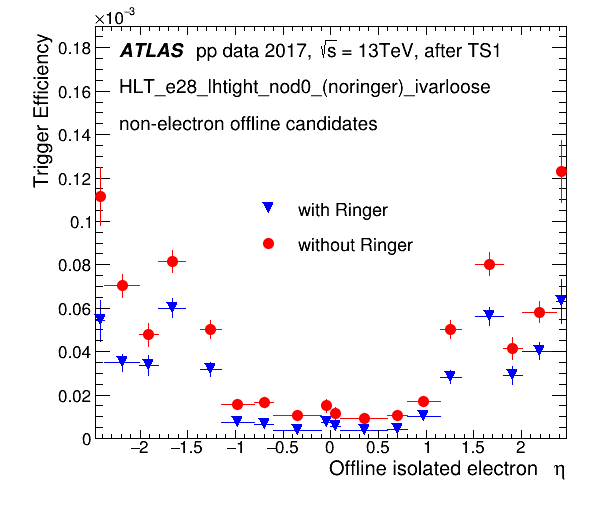

In [49]:
colors = [kBlue,kRed]
markers = [23, 20]
hists = [
            rpl.hist1d.divide(h_data17_after_ts1_egam7['HLT_e28_lhtight_nod0_ivarloose_HLT_match_eta'],
                              h_data17_after_ts1_egam7['HLT_e28_lhtight_nod0_ivarloose_HLT_eta']),
            rpl.hist1d.divide(h_data17_after_ts1_egam7['HLT_e28_lhtight_nod0_noringer_ivarloose_HLT_match_eta'],
                              h_data17_after_ts1_egam7['HLT_e28_lhtight_nod0_noringer_ivarloose_HLT_eta']),
]

fig = rpl.plot_profiles( hists, 'Offline isolated electron #eta',  'Trigger Efficiency', colors, markers,
                         name='',title='',canw=600, canh=550)
set_marker_size(fig, 1.4)
rpl.add_text( 0.2, 0.89, 'ATLAS'   , textsize=0.04, textfont=72)
rpl.add_text( 0.33, 0.89, 'pp data 2017, #sqrt{s} = 13TeV, after TS1', textsize=0.04)
rpl.add_text( 0.2, 0.82, 'HLT_e28_lhtight_nod0_(noringer)_ivarloose', textsize=0.04)
rpl.add_text( 0.2, 0.75, 'non-electron offline candidates', textsize=0.04)
add_legend( 0.4,0.5,['with Ringer', 'without Ringer'] , 20)
rpl.set_yaxis_ranges(0, 0.00019)

            
fig.show()
fig.savefig('output/eff_EGAM7_e28_ringer_and_noringer_2017_after_ts1_HLT_eta.pdf')

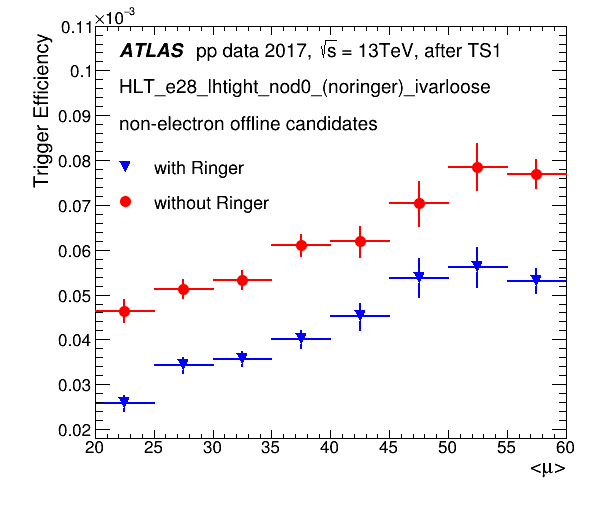

In [57]:
colors = [kBlue,kRed]
markers = [23, 20]
hists = [
            h_data17_after_ts1_egam7['HLT_e28_lhtight_nod0_ivarloose_HLT_match_mu'],
            h_data17_after_ts1_egam7['HLT_e28_lhtight_nod0_ivarloose_HLT_mu'],
            h_data17_after_ts1_egam7['HLT_e28_lhtight_nod0_noringer_ivarloose_HLT_match_mu'],
            h_data17_after_ts1_egam7['HLT_e28_lhtight_nod0_noringer_ivarloose_HLT_mu'],
        ]

hists = [ rpl.hist1d.rebin( h , 8, 20, 60 ) for h in hists ]
hists = [ rpl.hist1d.divide( hists[0], hists[1] ), rpl.hist1d.divide(hists[2], hists[3]) ]

fig = rpl.plot_profiles( hists, '<#mu>',  'Trigger Efficiency', colors, markers,
                        name='',title='',canw=600, canh=550)
set_marker_size(fig, 1.4)
rpl.add_text( 0.2, 0.89, 'ATLAS'   , textsize=0.04, textfont=72)
rpl.add_text( 0.33, 0.89, 'pp data 2017, #sqrt{s} = 13TeV, after TS1', textsize=0.04)
rpl.add_text( 0.2, 0.82, 'HLT_e28_lhtight_nod0_(noringer)_ivarloose', textsize=0.04)
rpl.add_text( 0.2, 0.75, 'non-electron offline candidates', textsize=0.04)
add_legend( 0.16,0.58,['with Ringer', 'without Ringer'] , 20)
rpl.set_yaxis_ranges(0.000018, 0.00011)
fig.show()
fig.savefig('output/eff_EGAM7_e28_ringer_and_noringer_2017_after_ts1_HLT_mu.pdf')

## 3) Official plots (2017 ringer vs noringer before and after TS1)

This section will plot all single triggers before and after ts1.
- oper markers: before TS1 (without ringer);
- close markers: after TS1 (with ringer)


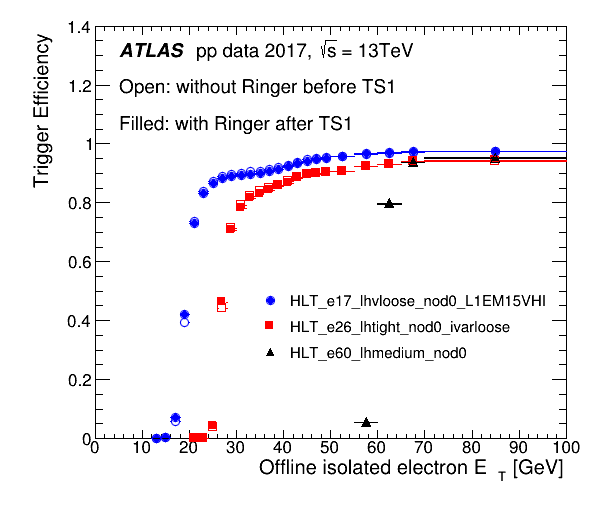

In [64]:
colors = [kBlue,kRed,kBlack, kBlue,kRed,kBlack]
markers = [20,21,22, 24,25,26]
hists = [

            rpl.hist1d.divide( h_data17_after_ts1['HLT_e17_lhvloose_nod0_L1EM15VHI_HLT_match_et'],
                               h_data17_after_ts1['HLT_e17_lhvloose_nod0_L1EM15VHI_HLT_et']),
            rpl.hist1d.divide( h_data17_after_ts1['HLT_e26_lhtight_nod0_ivarloose_HLT_match_et'],
                               h_data17_after_ts1['HLT_e26_lhtight_nod0_ivarloose_HLT_et']),
            rpl.hist1d.divide( h_data17_after_ts1['HLT_e60_lhmedium_nod0_HLT_match_et'],
                               h_data17_after_ts1['HLT_e60_lhmedium_nod0_HLT_et']),
            rpl.hist1d.divide( h_data17_before_ts1['HLT_e17_lhvloose_nod0_L1EM15VHI_HLT_match_et'],
                               h_data17_before_ts1['HLT_e17_lhvloose_nod0_L1EM15VHI_HLT_et']),
            rpl.hist1d.divide( h_data17_before_ts1['HLT_e26_lhtight_nod0_ivarloose_HLT_match_et'],
                               h_data17_before_ts1['HLT_e26_lhtight_nod0_ivarloose_HLT_et']),
            rpl.hist1d.divide( h_data17_before_ts1['HLT_e60_lhmedium_nod0_HLT_match_et'],
                               h_data17_before_ts1['HLT_e60_lhmedium_nod0_HLT_et']),

        ]
                              
fig = rpl.plot_profiles( hists, 'Offline isolated electron E_{T} [GeV]',  'Trigger Efficiency', colors, markers,
                         name='',title='',canw=600, canh=550)
set_marker_size(fig, 1.1)
rpl.add_text( 0.2, 0.89, 'ATLAS'   , textsize=0.04, textfont=72)
rpl.add_text( 0.33, 0.89, 'pp data 2017, #sqrt{s} = 13TeV', textsize=0.04)                
rpl.add_text( 0.2, 0.82, 'Open: without Ringer before TS1', textsize=0.04)
rpl.add_text( 0.2, 0.75, 'Filled: with Ringer after TS1', textsize=0.04)

legends = ['HLT_e17_lhvloose_nod0_L1EM15VHI','HLT_e26_lhtight_nod0_ivarloose','HLT_e60_lhmedium_nod0']
#rpl.add_legend( legends, 0.45,0.3,.98,0.6,textsize=16,option = 'p' )
add_legend( 0.42,0.3,legends,16 )

rpl.set_yaxis_ranges(0.0, 1.4)
fig.show()
fig.savefig('output/eff_EGAM1_e17_e26_e60_2017_before_and_after_ts1_et.pdf')

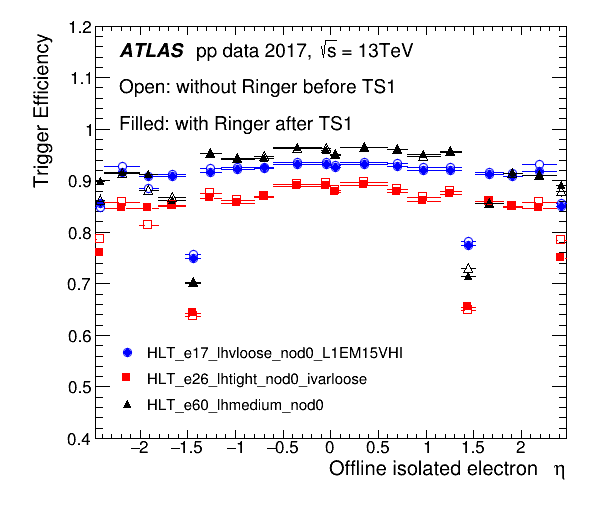

In [84]:
colors = [kBlue,kRed,kBlack, kBlue,kRed,kBlack]
markers = [20,21,22, 24,25,26]
hists = [

            rpl.hist1d.divide( h_data17_after_ts1['HLT_e17_lhvloose_nod0_L1EM15VHI_HLT_match_eta'],
                               h_data17_after_ts1['HLT_e17_lhvloose_nod0_L1EM15VHI_HLT_eta']),
            rpl.hist1d.divide( h_data17_after_ts1['HLT_e26_lhtight_nod0_ivarloose_HLT_match_eta'],
                               h_data17_after_ts1['HLT_e26_lhtight_nod0_ivarloose_HLT_eta']),
            rpl.hist1d.divide( h_data17_after_ts1['HLT_e60_lhmedium_nod0_HLT_match_eta'],
                               h_data17_after_ts1['HLT_e60_lhmedium_nod0_HLT_eta']),
            rpl.hist1d.divide( h_data17_before_ts1['HLT_e17_lhvloose_nod0_L1EM15VHI_HLT_match_eta'],
                               h_data17_before_ts1['HLT_e17_lhvloose_nod0_L1EM15VHI_HLT_eta']),
            rpl.hist1d.divide( h_data17_before_ts1['HLT_e26_lhtight_nod0_ivarloose_HLT_match_eta'],
                               h_data17_before_ts1['HLT_e26_lhtight_nod0_ivarloose_HLT_eta']),
            rpl.hist1d.divide( h_data17_before_ts1['HLT_e60_lhmedium_nod0_HLT_match_eta'],
                               h_data17_before_ts1['HLT_e60_lhmedium_nod0_HLT_eta']),

        ]
                              
fig = rpl.plot_profiles( hists, 'Offline isolated electron #eta',  'Trigger Efficiency', colors, markers,
                         name='',title='',canw=600, canh=550)
set_marker_size(fig, 1.1)
rpl.add_text( 0.2, 0.89, 'ATLAS'   , textsize=0.04, textfont=72)
rpl.add_text( 0.33, 0.89, 'pp data 2017, #sqrt{s} = 13TeV', textsize=0.04)                
rpl.add_text( 0.2, 0.82, 'Open: without Ringer before TS1', textsize=0.04)
rpl.add_text( 0.2, 0.75, 'Filled: with Ringer after TS1', textsize=0.04)              


legends = ['HLT_e17_lhvloose_nod0_L1EM15VHI','HLT_e26_lhtight_nod0_ivarloose','HLT_e60_lhmedium_nod0']

#rpl.add_legend( legends, 0.45,0.3,.98,0.6,textsize=16,option = 'p' )
add_legend( 0.18,0.2,legends,16 )

rpl.set_yaxis_ranges(0.4, 1.2)
fig.show()
fig.savefig('output/eff_EGAM1_e17_e26_e60_2017_before_and_after_ts1_eta.pdf')

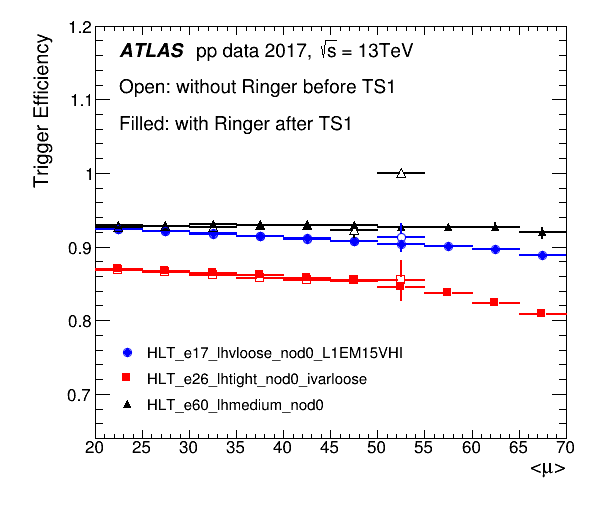

In [71]:
resize =  [10,20,70]
colors = [kBlue,kRed,kBlack, kBlue,kRed,kBlack]
markers = [20,21,22, 24,25,26]
hists = [

            h_data17_after_ts1['HLT_e17_lhvloose_nod0_L1EM15VHI_HLT_match_mu'],
            h_data17_after_ts1['HLT_e17_lhvloose_nod0_L1EM15VHI_HLT_mu'],
            h_data17_after_ts1['HLT_e26_lhtight_nod0_ivarloose_HLT_match_mu'],
            h_data17_after_ts1['HLT_e26_lhtight_nod0_ivarloose_HLT_mu'],
            h_data17_after_ts1['HLT_e60_lhmedium_nod0_HLT_match_mu'],
            h_data17_after_ts1['HLT_e60_lhmedium_nod0_HLT_mu'],
            h_data17_before_ts1['HLT_e17_lhvloose_nod0_L1EM15VHI_HLT_match_mu'],
            h_data17_before_ts1['HLT_e17_lhvloose_nod0_L1EM15VHI_HLT_mu'],
            h_data17_before_ts1['HLT_e26_lhtight_nod0_ivarloose_HLT_match_mu'],
            h_data17_before_ts1['HLT_e26_lhtight_nod0_ivarloose_HLT_mu'],
            h_data17_before_ts1['HLT_e60_lhmedium_nod0_HLT_match_mu'],
            h_data17_before_ts1['HLT_e60_lhmedium_nod0_HLT_mu'],
    
        ]

hists = [ rpl.hist1d.rebin( h , 10, 20, 70 ) for h in hists ]
hists = [ rpl.hist1d.divide( hists[0] , hists[1] ), 
          rpl.hist1d.divide( hists[2] , hists[3] ),
          rpl.hist1d.divide( hists[4] , hists[5] ),
          rpl.hist1d.divide( hists[6] , hists[7] ),
          rpl.hist1d.divide( hists[8] , hists[9] ),
          rpl.hist1d.divide( hists[10], hists[11]),
        ]

fig = rpl.plot_profiles( hists, '<#mu>',  'Trigger Efficiency', colors, markers,
                         name='',title='',canw=600, canh=550)
set_marker_size(fig, 1.1)
rpl.add_text( 0.2, 0.89, 'ATLAS'   , textsize=0.04, textfont=72)
rpl.add_text( 0.33, 0.89, 'pp data 2017, #sqrt{s} = 13TeV', textsize=0.04)                
rpl.add_text( 0.2, 0.82, 'Open: without Ringer before TS1', textsize=0.04)
rpl.add_text( 0.2, 0.75, 'Filled: with Ringer after TS1', textsize=0.04)
legends = ['HLT_e17_lhvloose_nod0_L1EM15VHI','HLT_e26_lhtight_nod0_ivarloose','HLT_e60_lhmedium_nod0']
#rpl.add_legend( legends, 0.45,0.3,.98,0.6,textsize=16,option = 'p' )
add_legend( 0.18,0.2,legends,16 )

rpl.set_yaxis_ranges(0.64, 1.2)

                        
fig.show()
fig.savefig('output/eff_EGAM1_e17_e26_e60_2017_before_and_after_ts1_mu.pdf')

## 4) Official plots (2017 (after TS1) and 2018 ringer vs noringer)

Here we will plot the comparison between ringer (v6), operating in 2017 after TS1, and ringer v8 (2018 tunings)

- 2017 after TS1: ringer v6 tunings;
- 2018: ringer v8 tunings;


### 4.2) HLT_e26_lhtight_nod0_ivarloose:

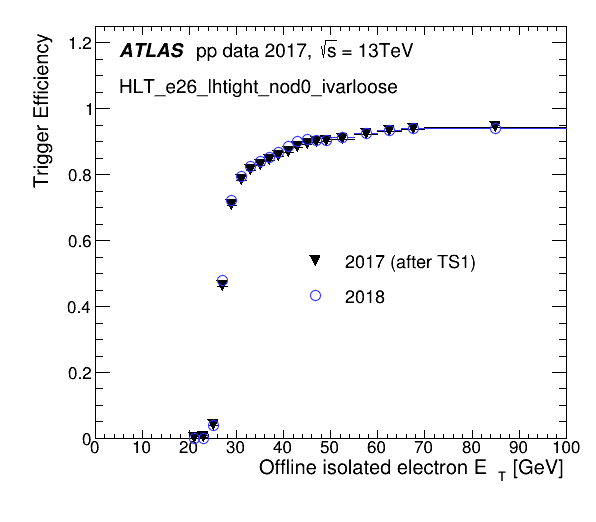

In [74]:
colors = [kBlack,kBlue-4]
markers = [23, 24]
hists = [
            rpl.hist1d.divide( h_data17_after_ts1['HLT_e26_lhtight_nod0_ivarloose_HLT_match_et'],
                               h_data17_after_ts1['HLT_e26_lhtight_nod0_ivarloose_HLT_et']),
            rpl.hist1d.divide( h_data18['HLT_e26_lhtight_nod0_ivarloose_HLT_match_et'],
                               h_data18['HLT_e26_lhtight_nod0_ivarloose_HLT_et']),
        ]

fig = rpl.plot_profiles( hists, 'Offline isolated electron E_{T} [GeV]' ,  'Trigger Efficiency', colors, markers ,
                         name='',title='',canw=600, canh=550)
set_marker_size(fig, 1.4)
rpl.add_text( 0.2, 0.89, 'ATLAS'   , textsize=0.04, textfont=72)
rpl.add_text( 0.33, 0.89, 'pp data 2017, #sqrt{s} = 13TeV', textsize=0.04)
rpl.add_text( 0.2, 0.82, 'HLT_e26_lhtight_nod0_ivarloose', textsize=0.04)
add_legend( 0.48, 0.4, ['2017 (after TS1)', '2018'], 20)

rpl.set_yaxis_ranges(0.0, 1.25)
fig.show()
fig.savefig('output/eff_EGAM1_e26_lhtight_nod0_ivarloose_2017_after_ts1_and_2018_et.pdf')

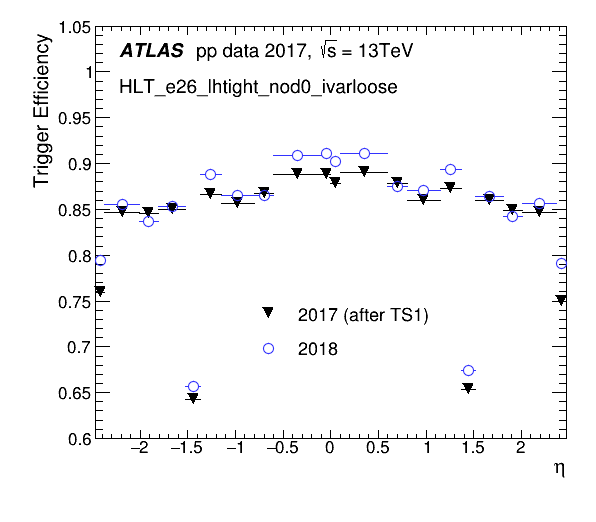

In [77]:
colors = [kBlack,kBlue-4]
markers = [23, 24]
hists = [
            rpl.hist1d.divide( h_data17_after_ts1['HLT_e26_lhtight_nod0_ivarloose_HLT_match_eta'],
                               h_data17_after_ts1['HLT_e26_lhtight_nod0_ivarloose_HLT_eta']),
            rpl.hist1d.divide( h_data18['HLT_e26_lhtight_nod0_ivarloose_HLT_match_eta'],
                               h_data18['HLT_e26_lhtight_nod0_ivarloose_HLT_eta']),
        ]

fig = rpl.plot_profiles( hists, '#eta',  'Trigger Efficiency', colors, markers,
                         name='',title='',canw=600, canh=550)
set_marker_size(fig, 1.4)
rpl.add_text( 0.2, 0.89, 'ATLAS'   , textsize=0.04, textfont=72)
rpl.add_text( 0.33, 0.89, 'pp data 2017, #sqrt{s} = 13TeV', textsize=0.04)
rpl.add_text( 0.2, 0.82, 'HLT_e26_lhtight_nod0_ivarloose', textsize=0.04)
add_legend( 0.4, 0.3, ['2017 (after TS1)', '2018'], 20)

rpl.set_yaxis_ranges(0.6, 1.05)
fig.show()
fig.savefig('output/eff_EGAM1_e26_lhtight_nod0_ivarloose_2017_after_ts1_and_2018_eta.pdf')

In [33]:
def make_table( data, trigger ):
    
    t = PrettyTable(['Level','Accept'])
    levels = ['L1Calo','L2Calo','L2','EFCalo','HLT']
                    
    for lev in levels:
        
        passed = data[trigger+'_'+lev+'_match_eta'].GetEntries()
        total = data[trigger+'_'+lev+'_eta'].GetEntries()
        eff = passed/total*100
        tex = '%1.2f (%d/%d)'%(eff,passed,total)
        t.add_row([lev, tex])
    print(t)

In [34]:
make_table(h_data17_after_ts1, 'HLT_e60_lhmedium_nod0')
make_table(h_data18, 'HLT_e60_lhmedium_nod0')

+--------+-------------------------+
| Level  |          Accept         |
+--------+-------------------------+
| L1Calo | 99.83 (1128205/1130155) |
| L2Calo | 99.83 (1128205/1130155) |
|   L2   | 97.88 (1106149/1130155) |
| EFCalo | 96.35 (1088913/1130155) |
|  HLT   | 92.86 (1049421/1130155) |
+--------+-------------------------+
+--------+-------------------------+
| Level  |          Accept         |
+--------+-------------------------+
| L1Calo | 99.76 (1806543/1810840) |
| L2Calo | 99.76 (1806541/1810840) |
|   L2   | 97.44 (1764564/1810840) |
| EFCalo | 95.89 (1736489/1810840) |
|  HLT   | 92.48 (1674612/1810840) |
+--------+-------------------------+
